# 序列模型  
### 序列假设
常见的假设是虽然特定值xt可能会改变，但是序列本身的动力学不会改变。这样的假设是合理的，因为新的动力学一定受新的数据影响，而我们不可能用目前所掌握的数据来预测新的动力学。统计学家称不变的动力学为静止的（stationary）。因此，整个序列的估计值都将通过以下的方式获得：  
$$
P(x_1,\ldots,x_T)=P(x_1)P(x_2\mid x_1)P(x_3\mid x_1,x_2)\cdots P(x_T\mid x_1,\ldots,x_{T-1})
$$
### 建模依据
已知序列$\{x_{t-1},\ldots,x_1\}$，要预测$x_t$，目标函数（损失函数）应该是$P(x_t\mid x_{t-1},\ldots,x_1)$，根据极大似然估计法，在已知$\{x_{t-1},\ldots,x_1\}$的情况下，模型参数（模型参数也是概率分布$P(x_t\mid x_{t-1},\ldots,x_1)$的参数）使得$x_t$为当前值的概率达到最大，即：  
$$
P(x_t\mid x_{t-1},\ldots,x_1)=P(x_t\mid f(x_{t-1},\ldots,x_1))
$$
其中$f(x_{t-1},\ldots,x_1)$就是模型的输出，当采用one-hot编码时，$f(x_{t-1},\ldots,x_1)$就是$P(x_t\mid x_{t-1},\ldots,x_1)$。  

### 建模方案
主要问题：输入数据的数量，输入$x_{t-1},\ldots,x_1$本身因$t$而异。也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理。  

方法一：马尔科夫假设  
使用$x_{t-1},\ldots,x_{t-\tau}$而不是$x_{t-1},\ldots,x_1$来估计$x_t$。只要这种是近似精确的，我们就说序列满足马尔可夫条件（Markov condition）。特别是，如果$\tau = 1$，得到一个 一阶马尔可夫模型（first‐order Markov model）， $P(x)$由下式给出：  
$$
P(x_1,\ldots,x_T) = \prod_{t=1}^T P(x_t\mid x_{t-1})当P(x_1\mid x_0)=P(x_1)\\
P(x_{t+1}\mid x_t,x_{t-1})=P(x_{t+1}\mid x_t)
$$  

方法二：引入潜变量  
保留一些对过去观测的总结$h_{t-1}$，并且同时更新预测$\hat x_t$和总结$h_t$。这就产生了基于$\hat x_t=P(x_t\mid h_t)$用于估计$x_t$，以及公式$h_t=g(h_{t−1},x_{t−1})$更新的模型。  
![潜变量自回归模型](picture\latent_variable.jpg)

### 训练  

首先，我们生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据，时间步为1, 2, . . . , 1000

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

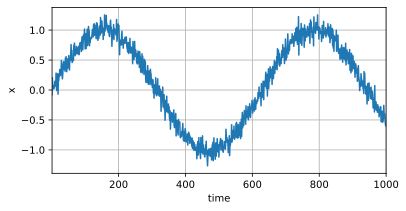

In [3]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.1, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
tau = 4
features = torch.zeros((T -tau, tau)) # 不包括最后一个值
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), 
                            batch_size, is_train=True)

在这里，我们使用一个相当简单的架构训练模型：一个拥有两个全连接层的多层感知机， ReLU激活函数和平方损失。

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10), 
        nn.ReLU(), 
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, ', f'loss {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,  loss 0.040111
epoch 2,  loss 0.019188
epoch 3,  loss 0.018105
epoch 4,  loss 0.017086
epoch 5,  loss 0.016181


### 预测  

首先是检查模型预测下一个时间步的能力，也就是单步预测（one‐step‐ahead prediction）。

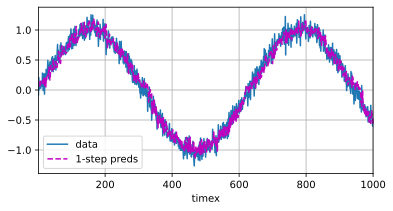

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time'
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], 
         figsize=(6, 3))

如果数据观察序列的时间步只到604，我们需要一步一步地向前迈进，换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行它的$k$步预测是$\hat x_{604+k}$

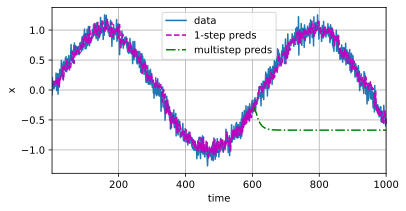

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau] # x_604, x_605, x_606, x_607
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape(1, -1))

d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(), 
          multistep_preds[n_train + tau:].detach().numpy()], 'time', 
          'x', legend=['data', '1-step preds', 'multistep preds'], 
          xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。事实是由于错误的累积：假设在步骤1之后，我们积累了一些错误$\epsilon_1=\bar\epsilon$。于是，步骤2的输入被扰动了$\epsilon_1$，结果积累的误差是依照次序的$\epsilon_2=\bar\epsilon+c\epsilon_1 $，其中$c$为某个常数，后面的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。

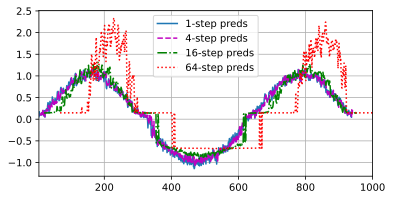

In [ ]:
max_steps = 64
# 窗口长度：tau+max_steps，可以划分出T - tau - max_steps + 1个窗口（与卷积相同）
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    # 每个窗口的前tau个数据为真实值
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    # 每个窗口的后max_steps个数据，每个数据由它前面的tau个数据预测得到
    # 每个窗口的前tau个数据进行了i步预测，1 <= i <= max_steps
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps], # 第i步预测对应的时间范围
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], # 第i步预测值
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], 
         figsize=(6, 3))